In [1]:
# Allow importing from the code directory.
import sys
sys.path.append('../code/')

In [2]:
import pandas as pd
import numpy as np

from etch import load_census

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.metrics import classification_report, confusion_matrix

import xgboost
import shap

import matplotlib.pyplot as plt

In [3]:
# Load the census dataset.
census = load_census()

In [4]:
nominal = census.nominal_features.copy()
continuous = census.continuous_features.copy()
continuous.remove("instance weight")

In [5]:
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(census.y_train)
y_test_encoded = encoder.transform(census.y_test)

In [6]:
X_train = census.X_train.copy().drop(columns=["instance weight"], axis=1)
X_test = census.X_test.copy().drop(columns=["instance weight"], axis=1)

In [7]:
encoder = OrdinalEncoder()
encoder.fit(X_train[nominal]);

In [8]:
X_train_encoded = pd.concat([
    pd.DataFrame(encoder.transform(X_train[nominal]), columns=nominal),
    pd.DataFrame(X_train[continuous], columns=continuous)
], axis=1)[X_train.columns]

X_test_encoded = pd.concat([
    pd.DataFrame(encoder.transform(X_test[nominal]), columns=nominal),
    pd.DataFrame(X_test[continuous], columns=continuous)
], axis=1)[X_test.columns]


In [9]:
model = xgboost.XGBClassifier(n_estimators=100, max_depth=2, random_state=42).fit(X_train_encoded, y_train_encoded)

explainer = shap.Explainer(model, X_train_encoded)
shap_values = explainer(X_test_encoded)

100%|===================| 99653/99762 [00:27<00:00]        

In [10]:
y_test_predictions = model.predict(X_test_encoded)

In [11]:
print(classification_report(y_test_encoded, y_test_predictions))
confusion_matrix(y_test_encoded, y_test_predictions)

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     93576
           1       0.75      0.41      0.53      6186

    accuracy                           0.95     99762
   macro avg       0.85      0.70      0.75     99762
weighted avg       0.95      0.95      0.95     99762



array([[92716,   860],
       [ 3642,  2544]])

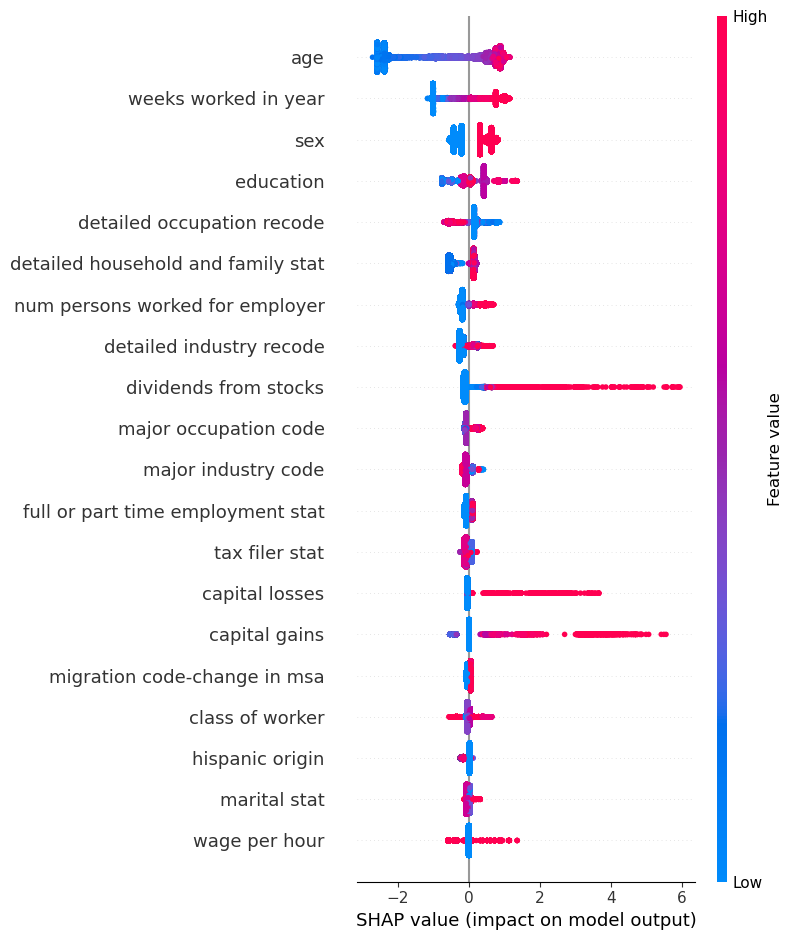

In [12]:
shap.summary_plot(shap_values, X_test_encoded, feature_names=X_test_encoded.columns)

<Figure size 640x480 with 0 Axes>

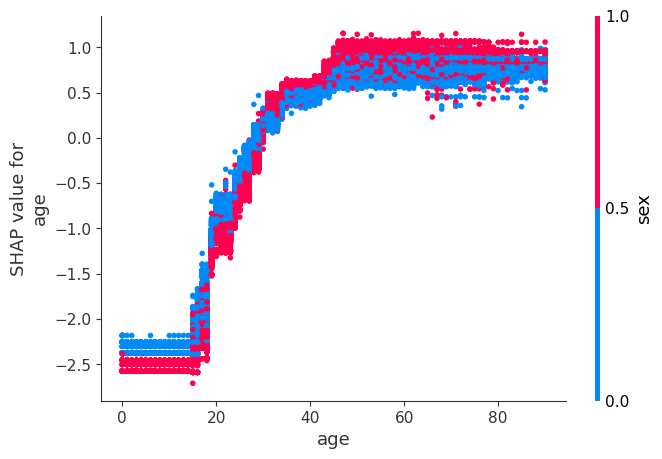

<Figure size 640x480 with 0 Axes>

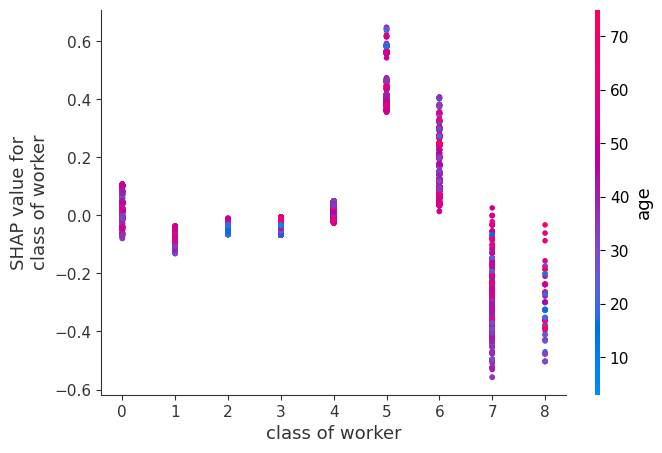

<Figure size 640x480 with 0 Axes>

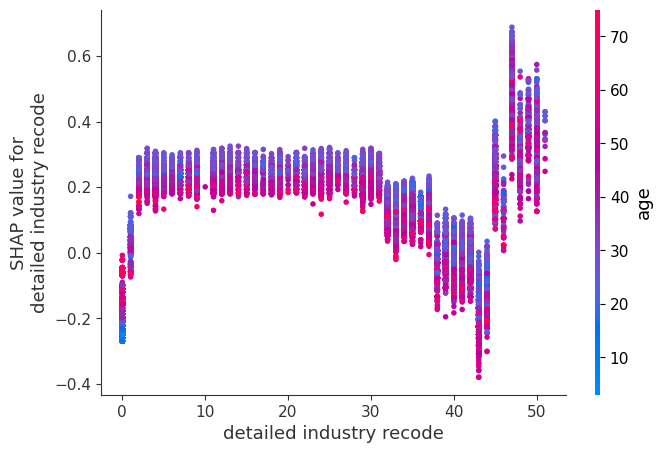

<Figure size 640x480 with 0 Axes>

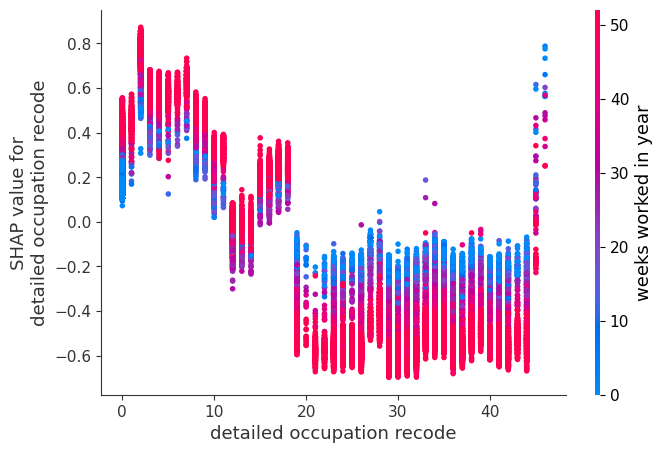

<Figure size 640x480 with 0 Axes>

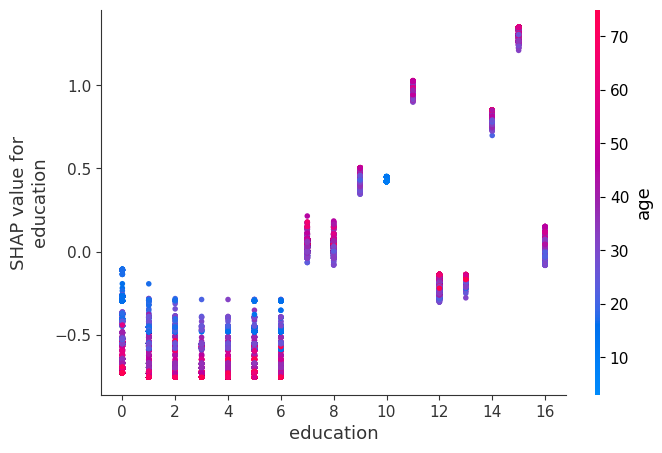

<Figure size 640x480 with 0 Axes>

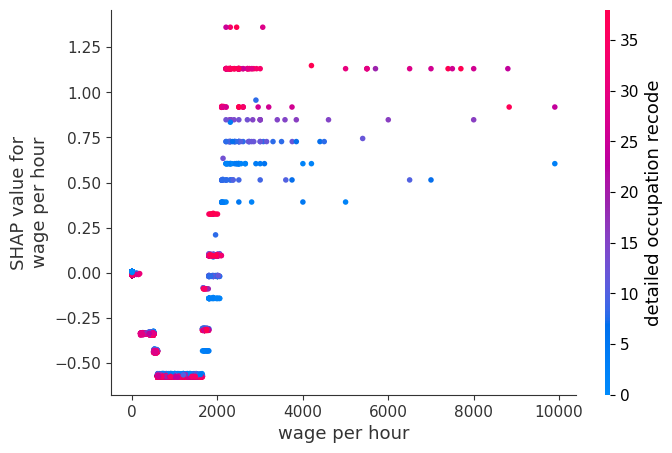

<Figure size 640x480 with 0 Axes>

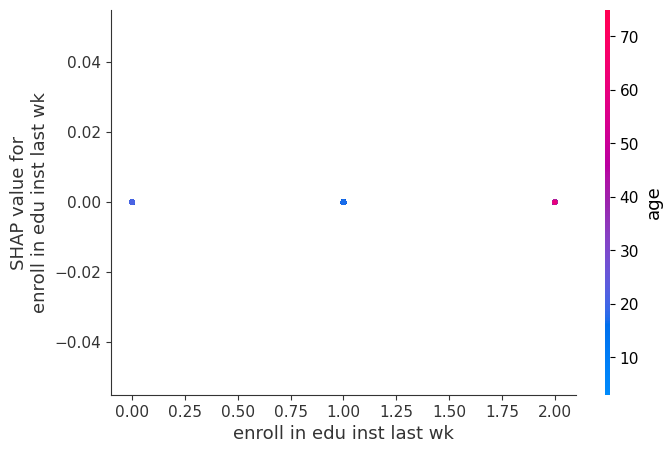

<Figure size 640x480 with 0 Axes>

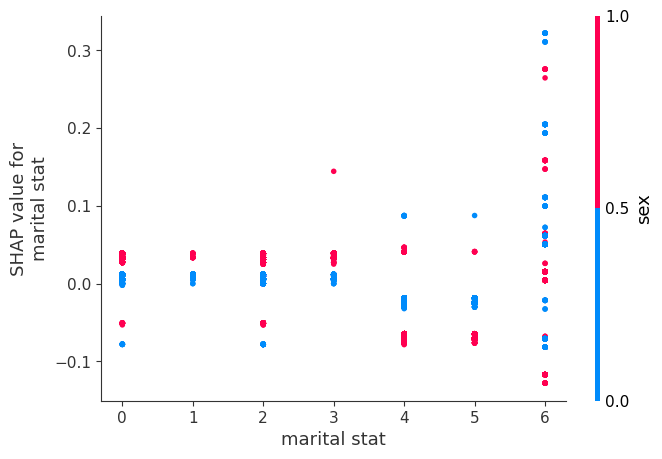

<Figure size 640x480 with 0 Axes>

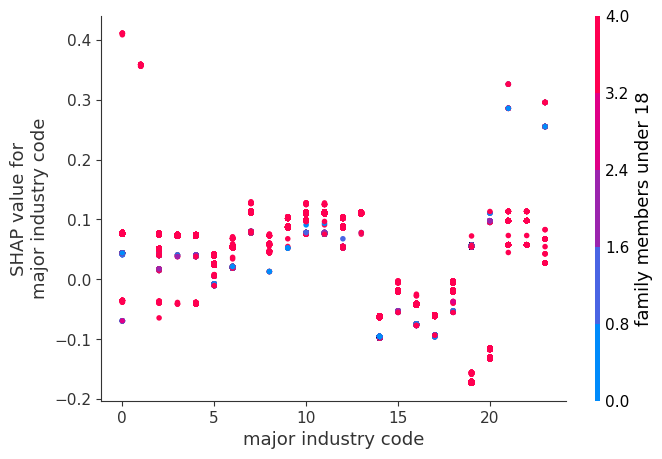

<Figure size 640x480 with 0 Axes>

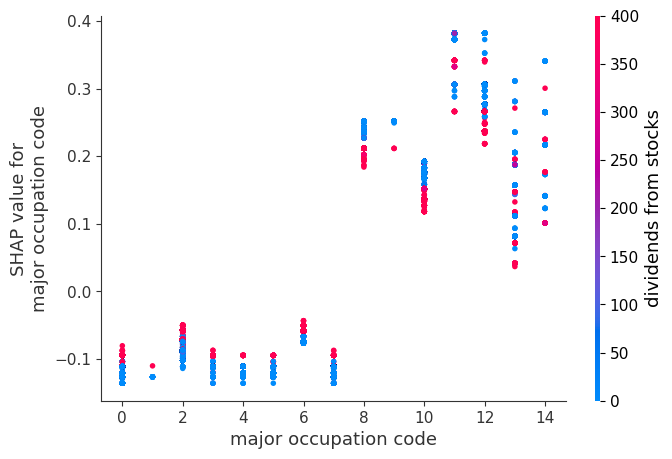

<Figure size 640x480 with 0 Axes>

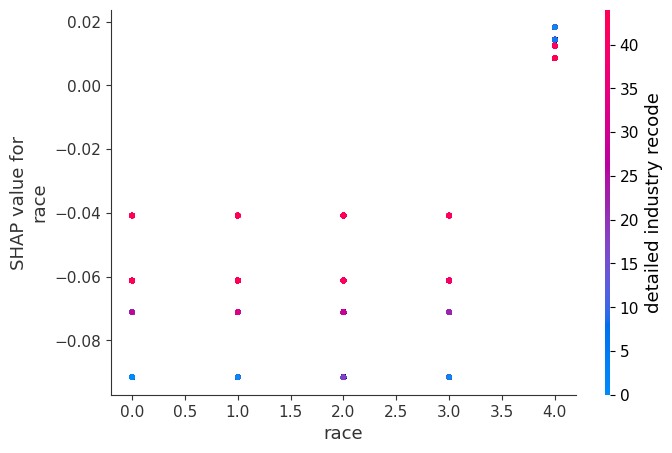

<Figure size 640x480 with 0 Axes>

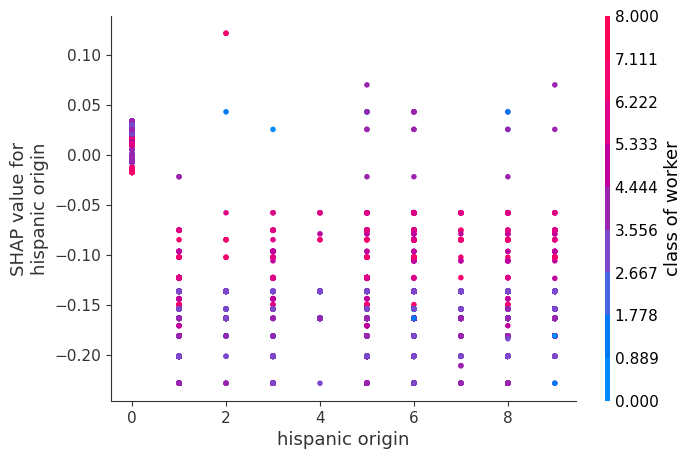

<Figure size 640x480 with 0 Axes>

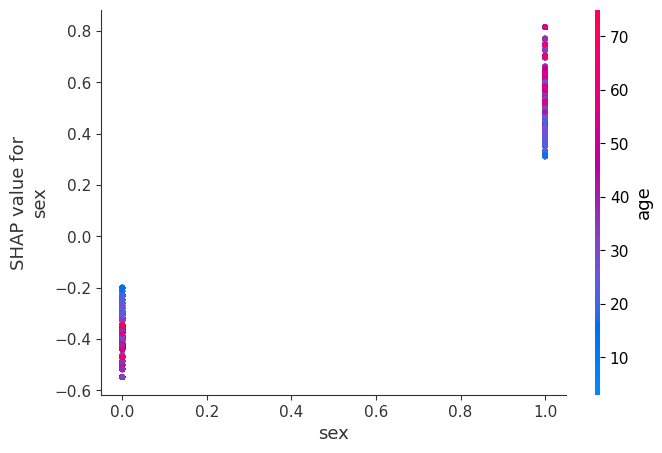

<Figure size 640x480 with 0 Axes>

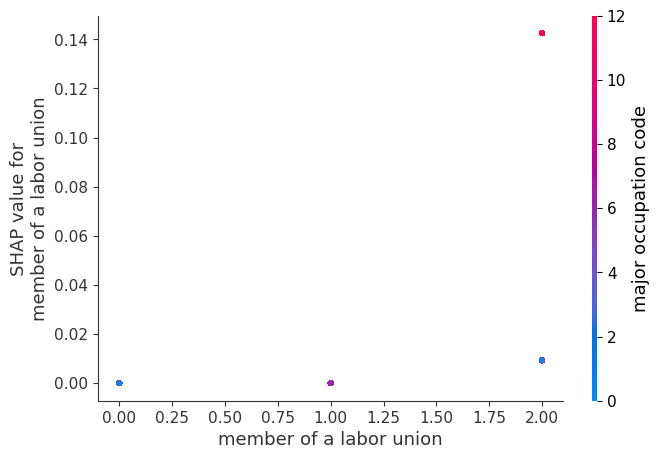

<Figure size 640x480 with 0 Axes>

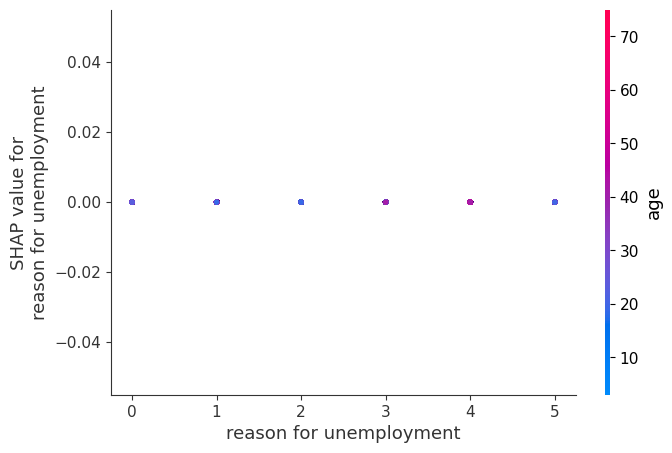

<Figure size 640x480 with 0 Axes>

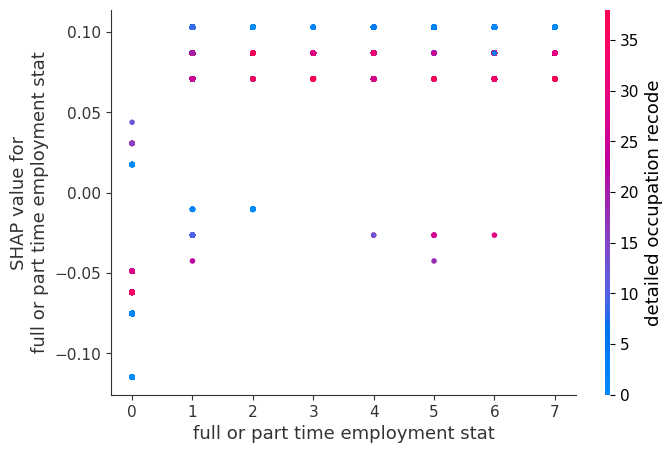

<Figure size 640x480 with 0 Axes>

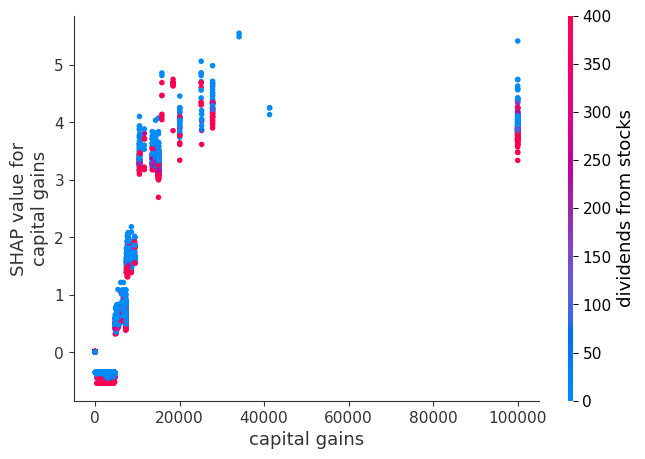

<Figure size 640x480 with 0 Axes>

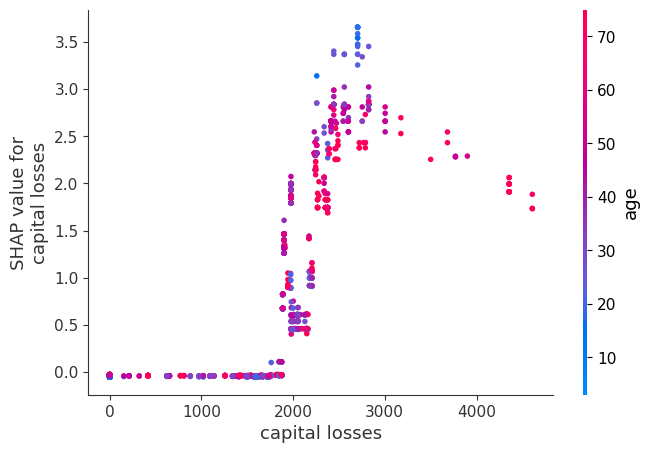

<Figure size 640x480 with 0 Axes>

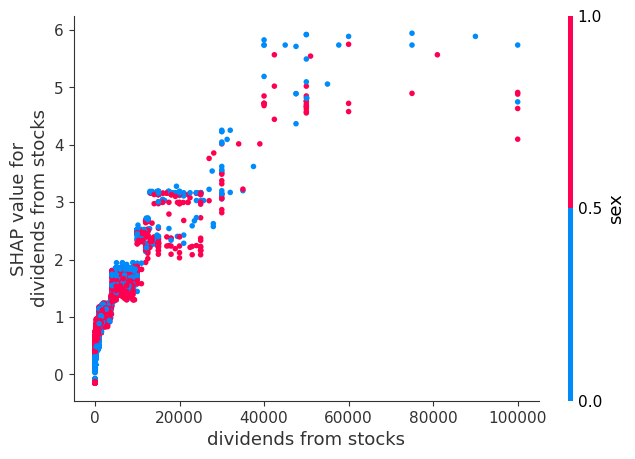

<Figure size 640x480 with 0 Axes>

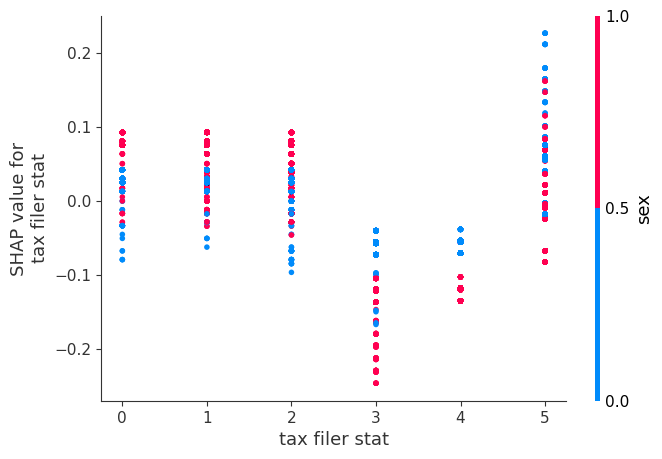

<Figure size 640x480 with 0 Axes>

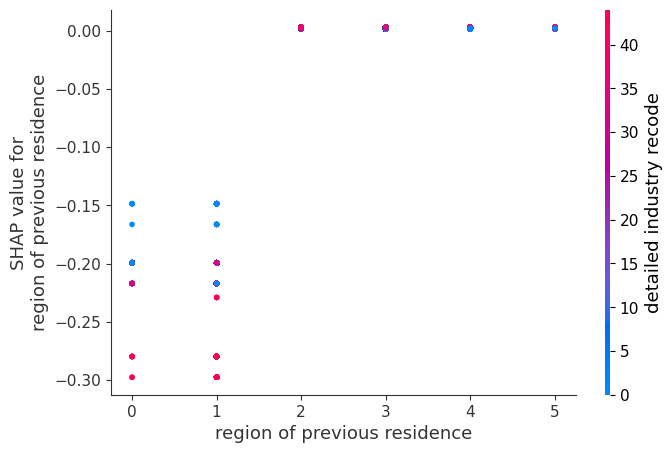

<Figure size 640x480 with 0 Axes>

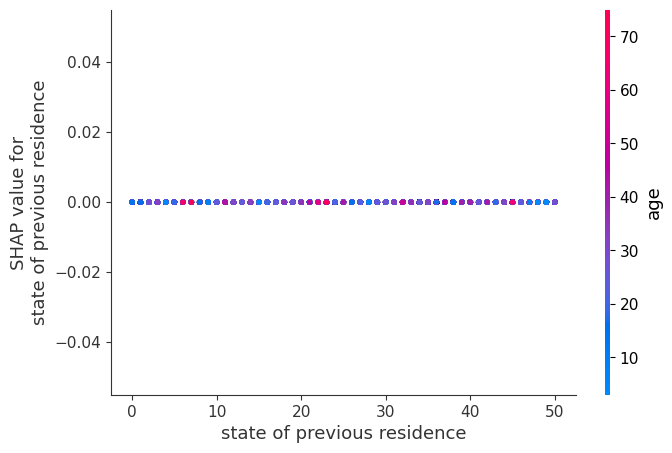

<Figure size 640x480 with 0 Axes>

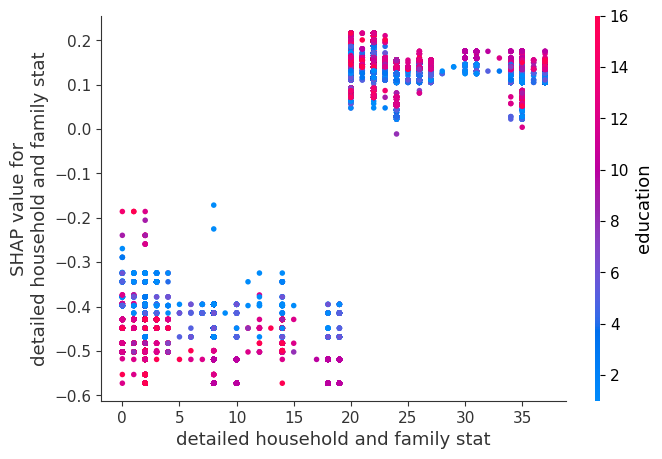

<Figure size 640x480 with 0 Axes>

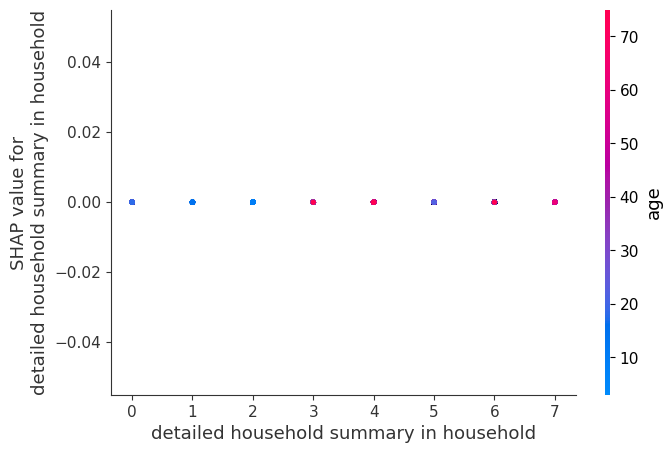

<Figure size 640x480 with 0 Axes>

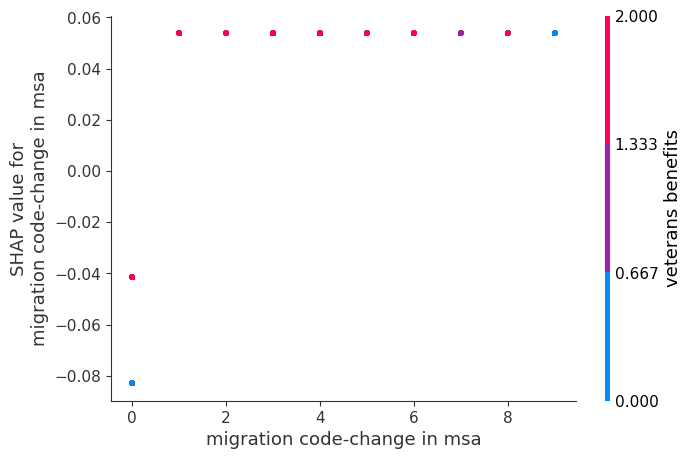

<Figure size 640x480 with 0 Axes>

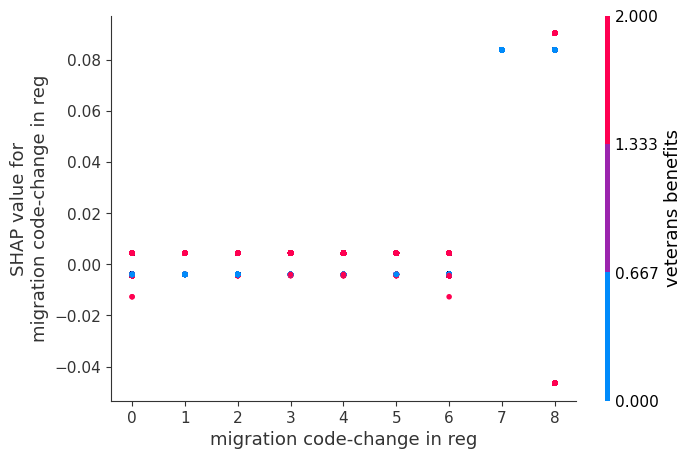

<Figure size 640x480 with 0 Axes>

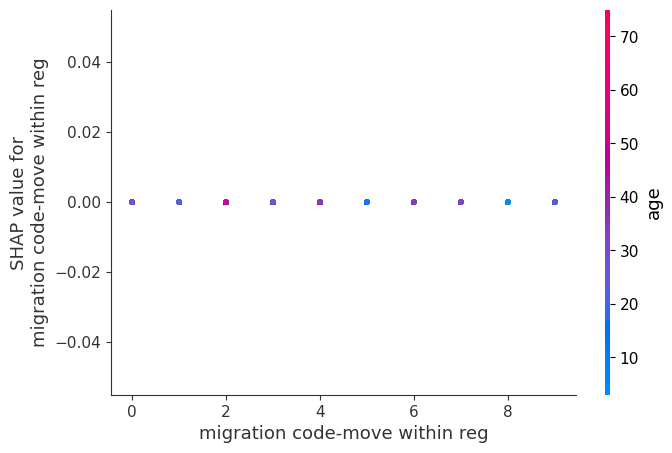

<Figure size 640x480 with 0 Axes>

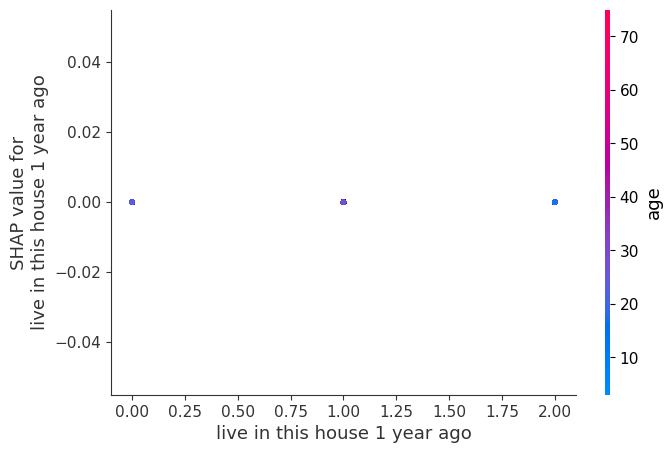

<Figure size 640x480 with 0 Axes>

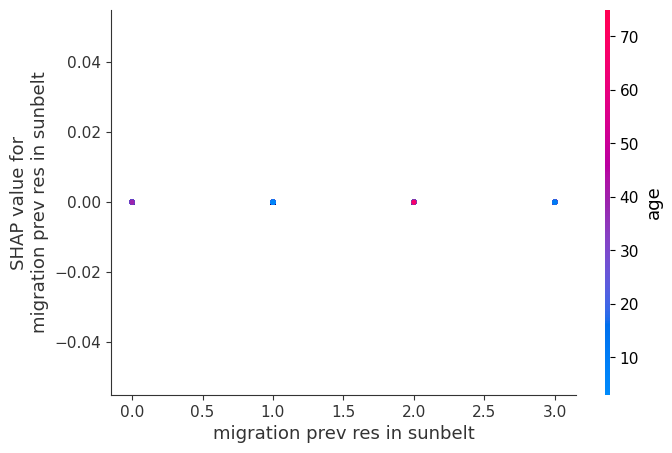

<Figure size 640x480 with 0 Axes>

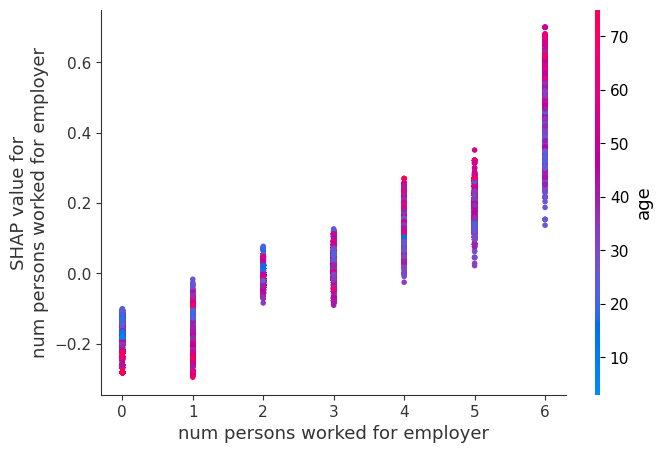

<Figure size 640x480 with 0 Axes>

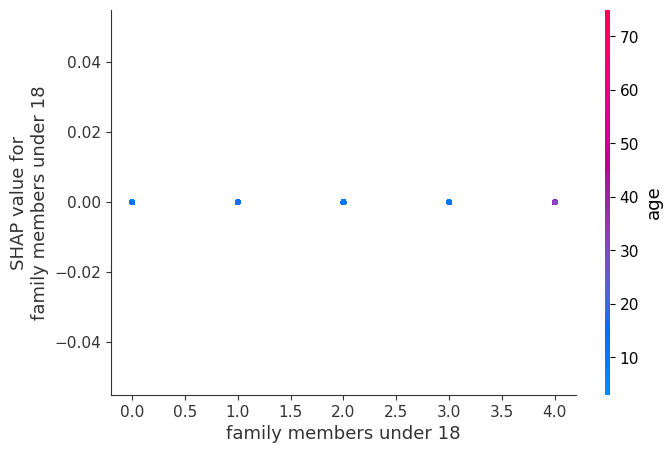

<Figure size 640x480 with 0 Axes>

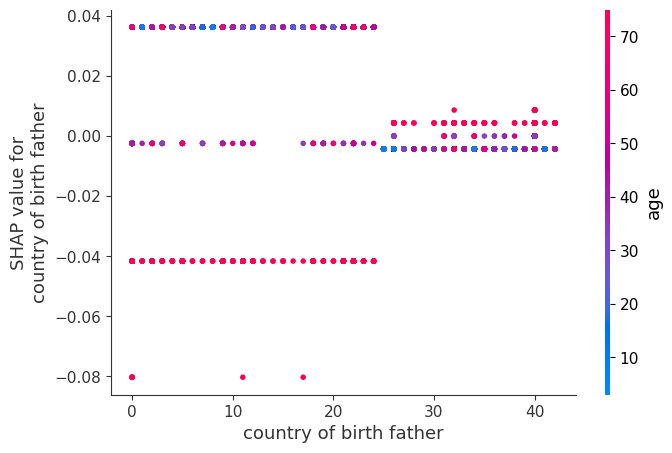

<Figure size 640x480 with 0 Axes>

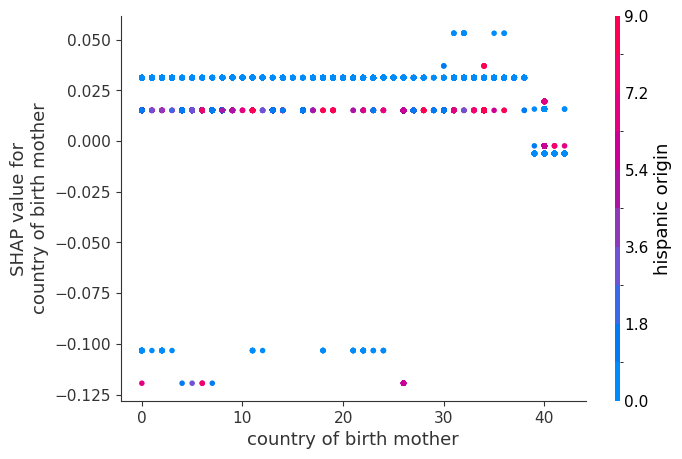

<Figure size 640x480 with 0 Axes>

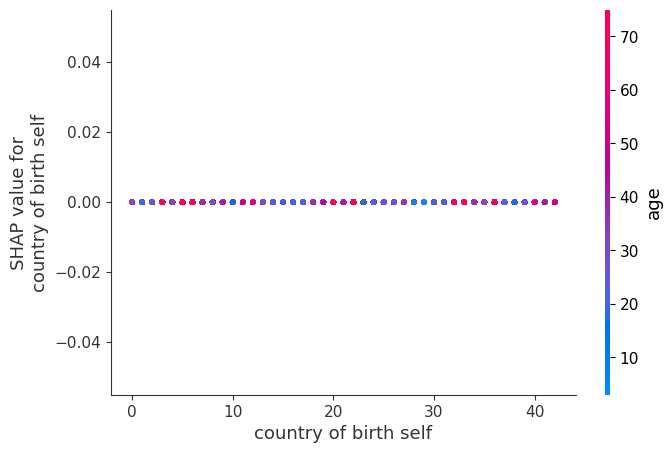

<Figure size 640x480 with 0 Axes>

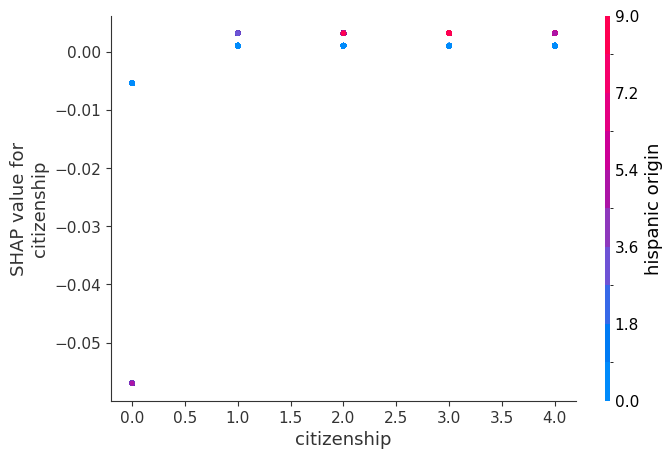

<Figure size 640x480 with 0 Axes>

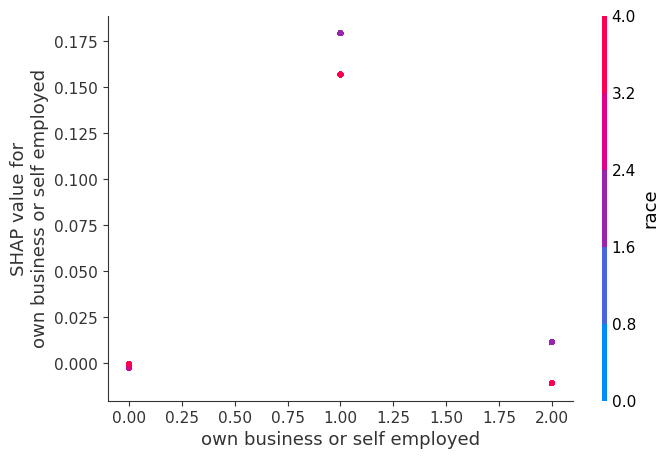

<Figure size 640x480 with 0 Axes>

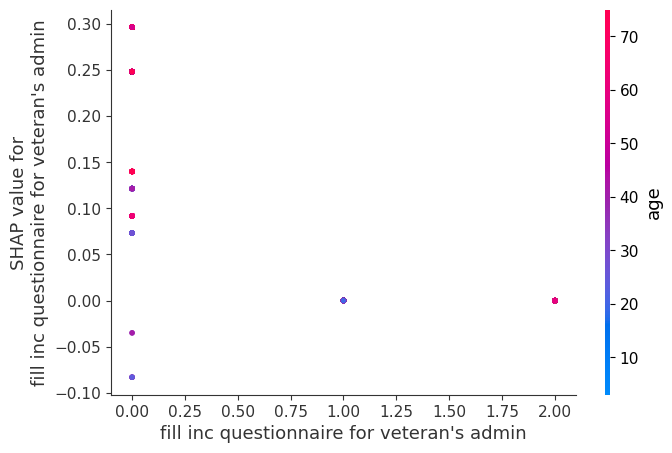

<Figure size 640x480 with 0 Axes>

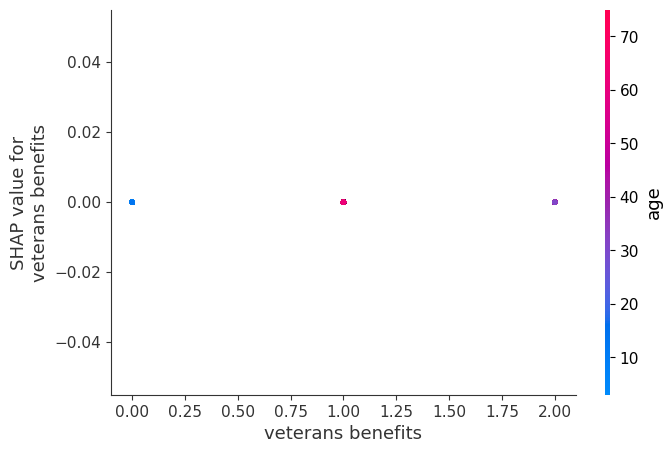

<Figure size 640x480 with 0 Axes>

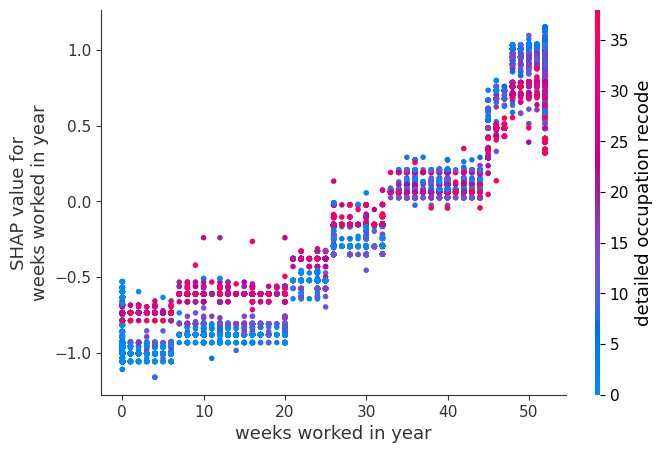

<Figure size 640x480 with 0 Axes>

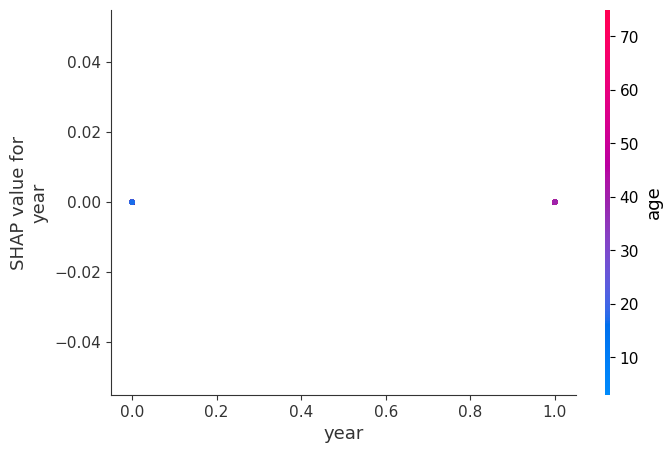

In [13]:
for i in range(X_test.shape[1]):
    plt.figure()
    shap.dependence_plot(i, shap_values.values, X_test_encoded)
    plt.show()

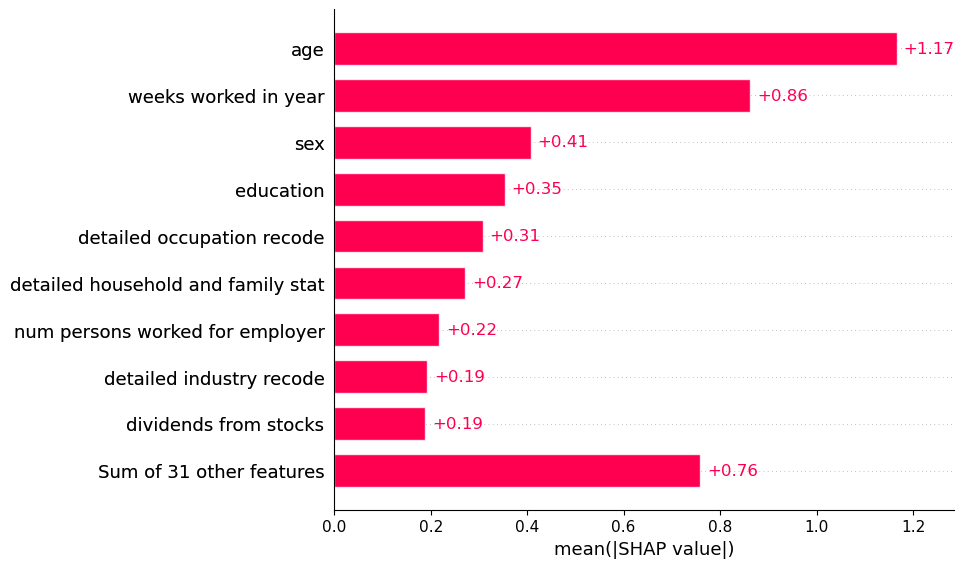

In [14]:
shap.plots.bar(shap_values, max_display=10)

In [15]:
fp = (y_test_predictions == 1) & (y_test_encoded == 0)
shap_values_tp = shap_values[(y_test_predictions == 1) & (y_test_encoded == 1)]
shap_values_fp = shap_values[fp]
shap_values_tn = shap_values[(y_test_predictions == 0) & (y_test_encoded == 0)]
shap_values_fn = shap_values[(y_test_predictions == 0) & (y_test_encoded == 1)]


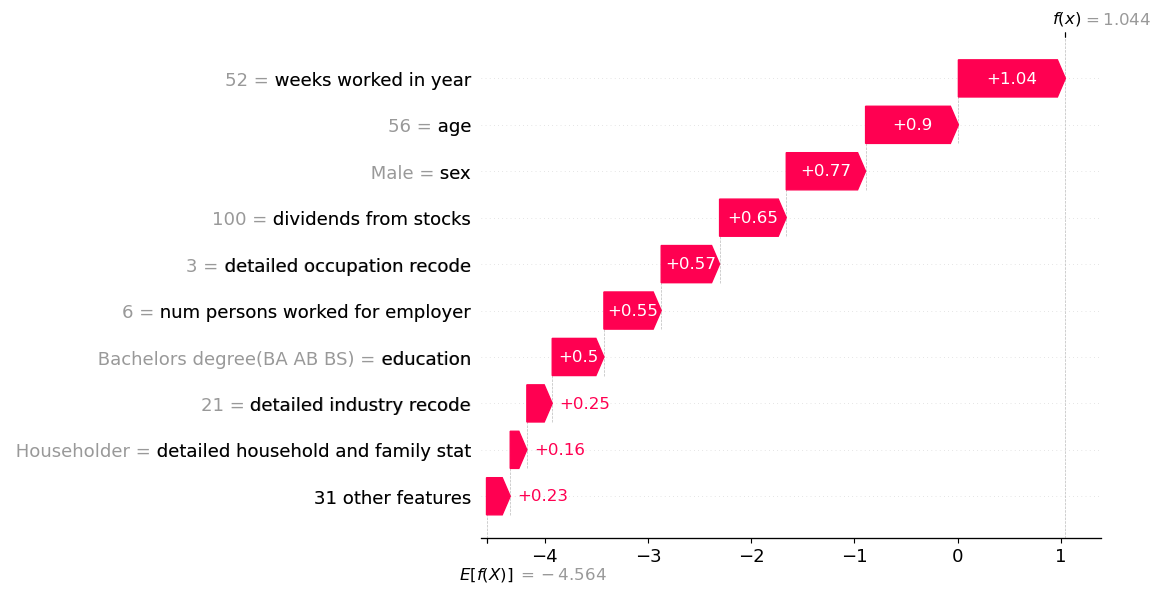

In [16]:
shap_values_fp.data = X_test[fp].values
shap.plots.waterfall(shap_values_fp[600], max_display=10)
shap_values_fp.data = X_test_encoded[fp].values

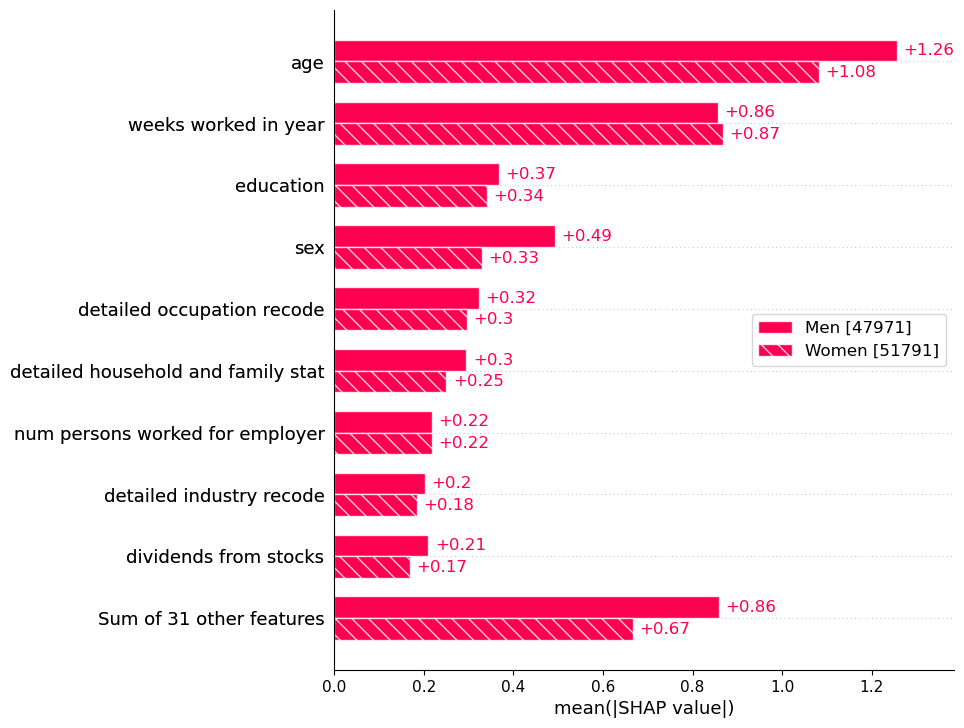

In [17]:
sex = ["Women" if shap_values[i, "sex"].data == 0 else "Men" for i in range(shap_values.shape[0])]
shap.plots.bar(shap_values.cohorts(sex).abs.mean(0))

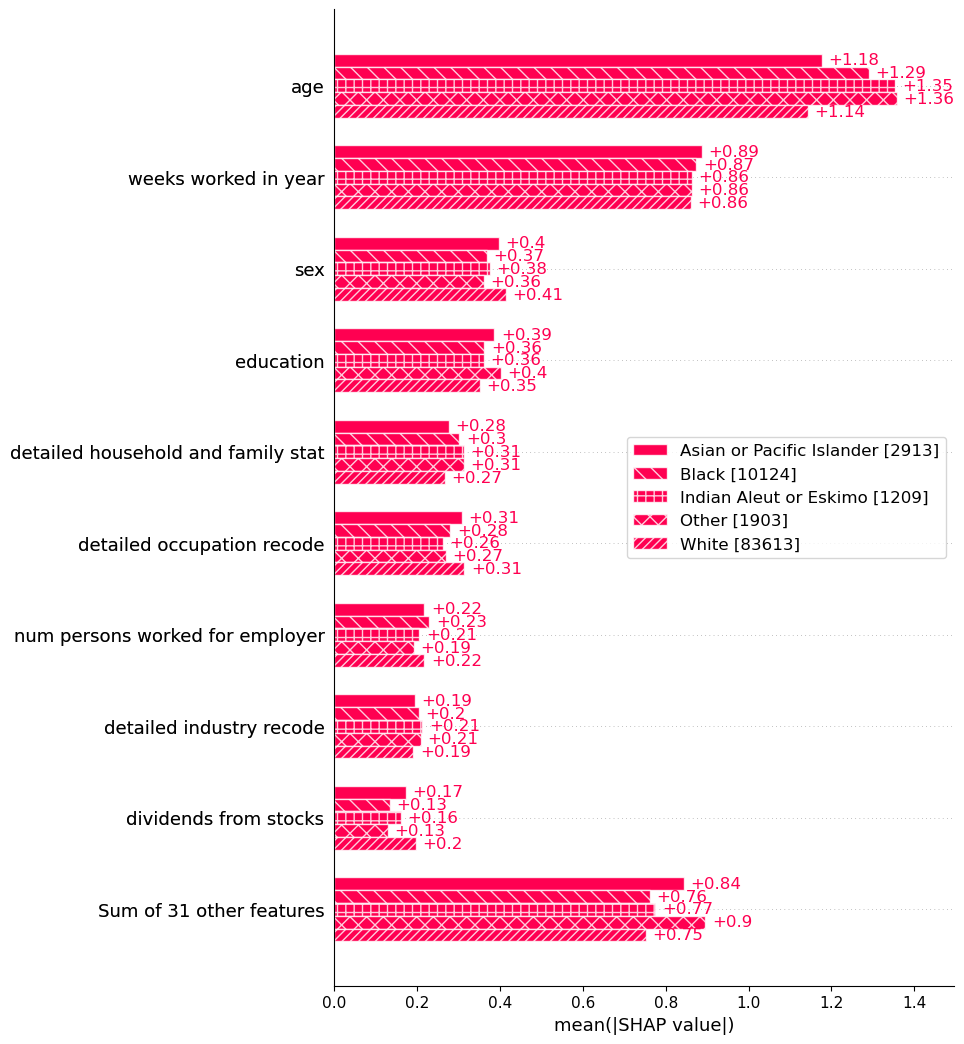

In [18]:
race = [
    "White" if shap_values[i, "race"].data == 4 else
    "Black" if shap_values[i, "race"].data == 2 else
    "Asian or Pacific Islander" if shap_values[i, "race"].data == 1 else
    "Other" if shap_values[i, "race"].data == 3 else
    "Indian Aleut or Eskimo"
    for i in range(shap_values.shape[0])
]

shap.plots.bar(shap_values.cohorts(race).abs.mean(0))

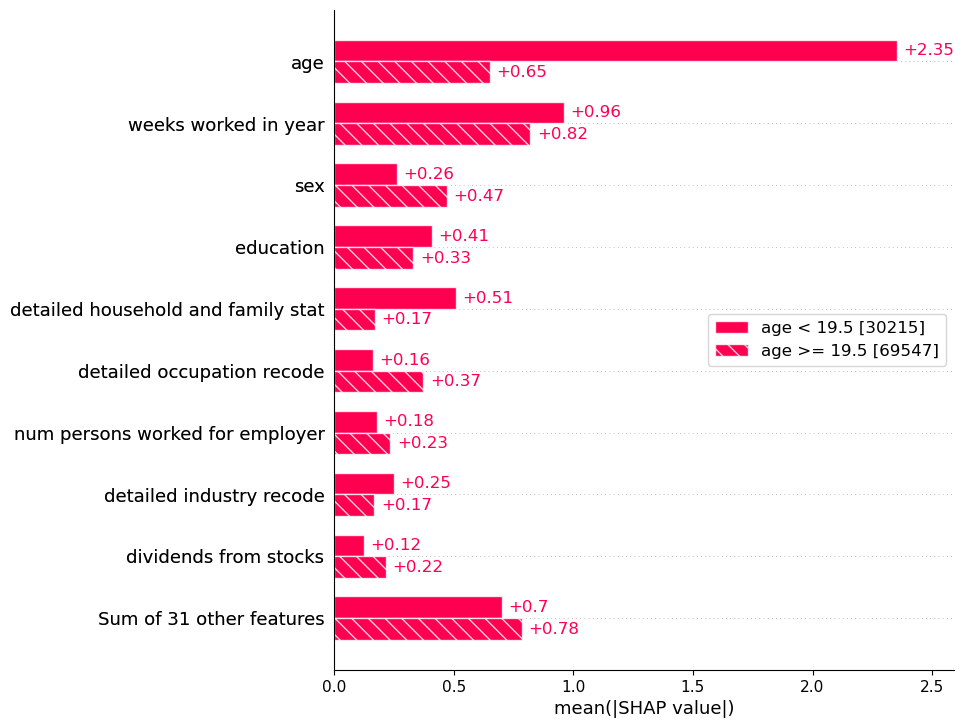

In [19]:
shap.plots.bar(shap_values.cohorts(2).abs.mean(0))

In [20]:
# Xf = X_train_encoded[X_train_encoded["age"] > 19]
# yf = y_train_encoded[X_train_encoded["age"] > 19]
# Xf_test = X_test_encoded[X_test_encoded["age"] > 19]

# model = xgboost.XGBClassifier(n_estimators=100, max_depth=2).fit(Xf, yf)

# explainerf = shap.Explainer(model, Xf)
# shap_valuesf = explainer(Xf_test)

# shap.plots.bar(shap_valuesf.cohorts(2).abs.mean(0))


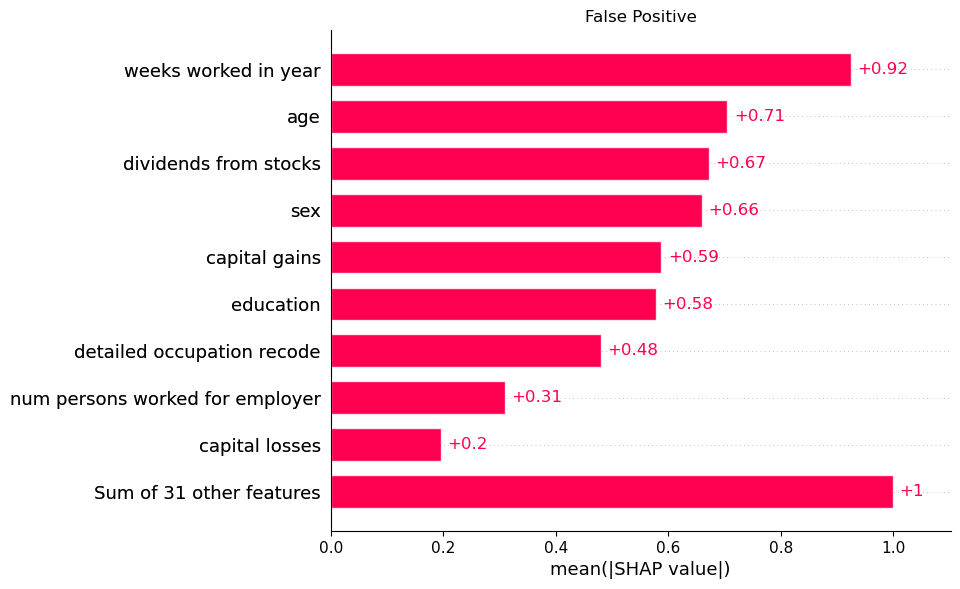

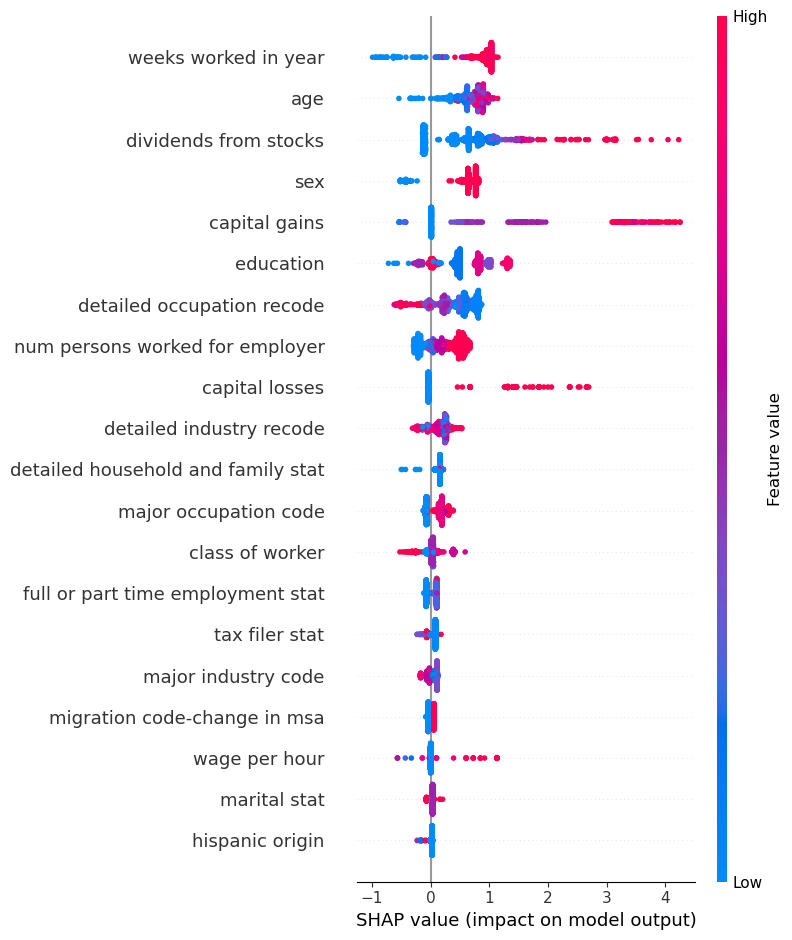

In [21]:
shap.plots.bar(shap_values_fp, max_display=10, show=False)
plt.title('False Positive')
plt.savefig('../results/shap_fp.png', format='png', dpi=300, bbox_inches='tight')
plt.show()
shap.summary_plot(shap_values_fp)


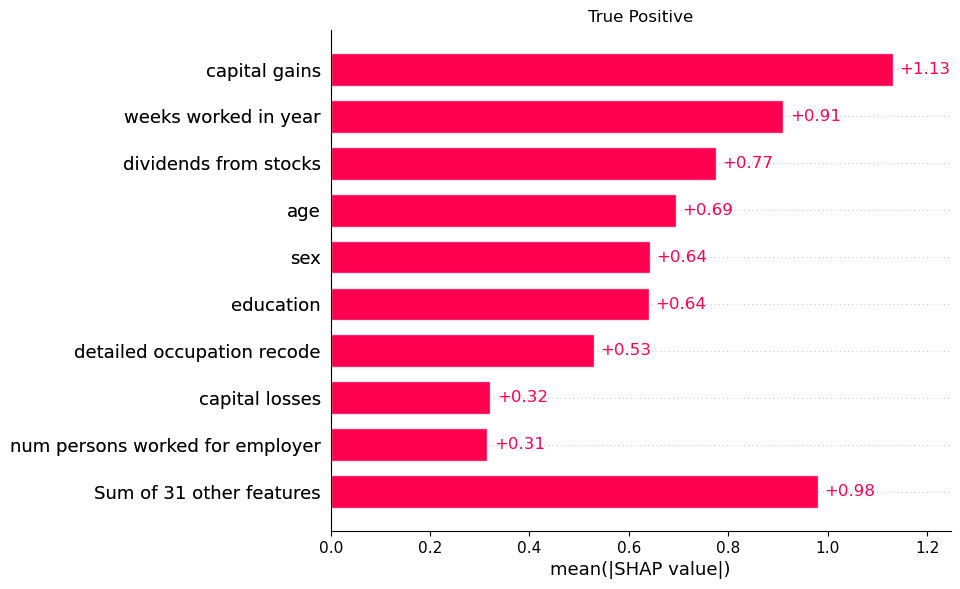

In [22]:
shap.plots.bar(shap_values_tp, max_display=10, show=False)
plt.title('True Positive')
plt.savefig('../results/shap_tp.png', format='png', dpi=300, bbox_inches='tight')

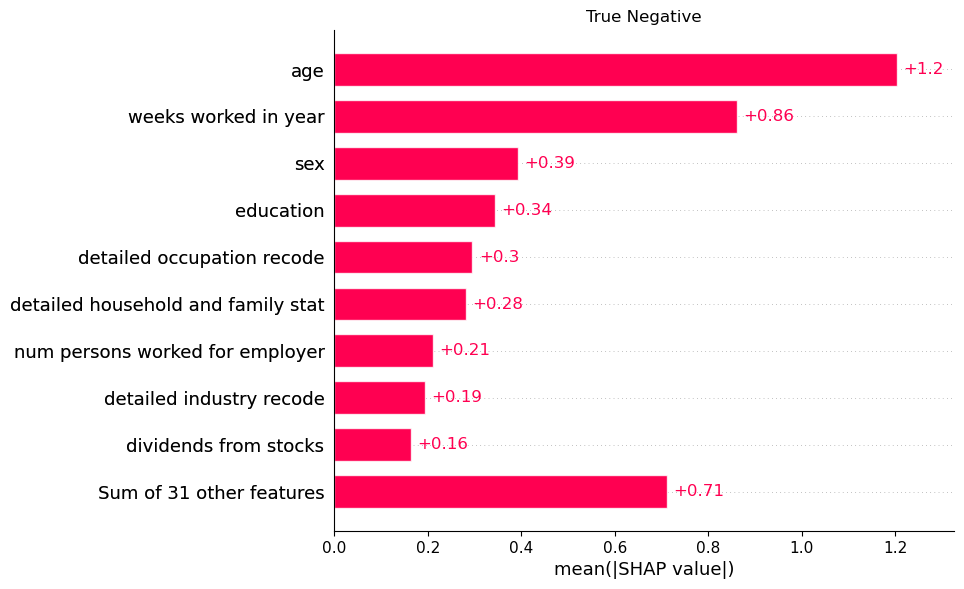

In [23]:
shap.plots.bar(shap_values_tn, max_display=10, show=False)
plt.title('True Negative')
plt.savefig('../results/shap_tn.png', format='png', dpi=300, bbox_inches='tight')

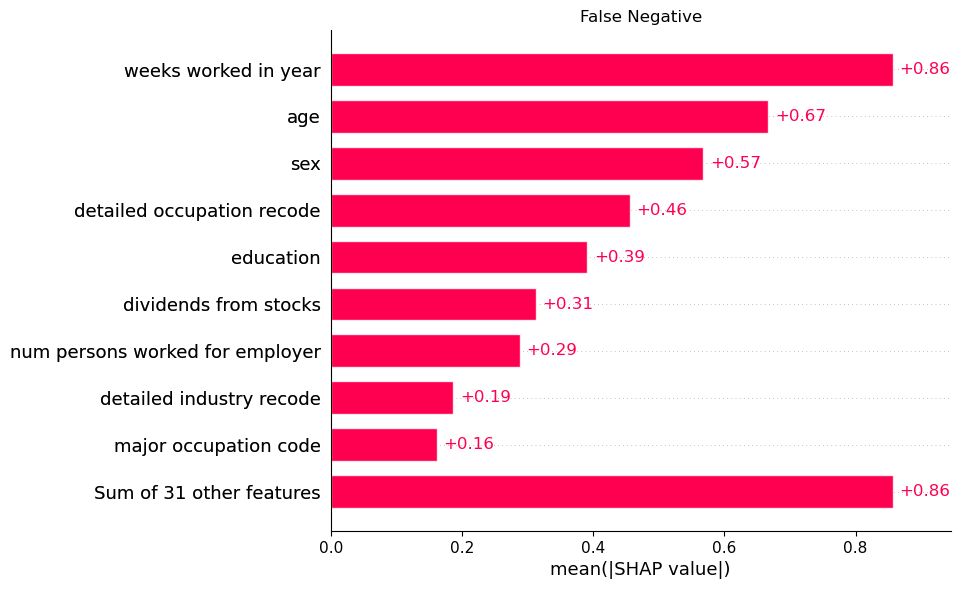

In [24]:
shap.plots.bar(shap_values_fn, max_display=10, show=False)
plt.title('False Negative')
plt.savefig('../results/shap_fn.png', format='png', dpi=300, bbox_inches='tight')